## Setup, Loading Data and CDFs

In [3]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'red'

In [4]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_wavelet_full_pastis.ipynb


In [5]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/results/case-studies/pastis/full/wavelet/red'

In [6]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [7]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [8]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 3180, 3: 12720, 4: 50880, 5: 203520, 6: 814080, 7: 3256320, 8: 13025280}

Running 12760 CDFs


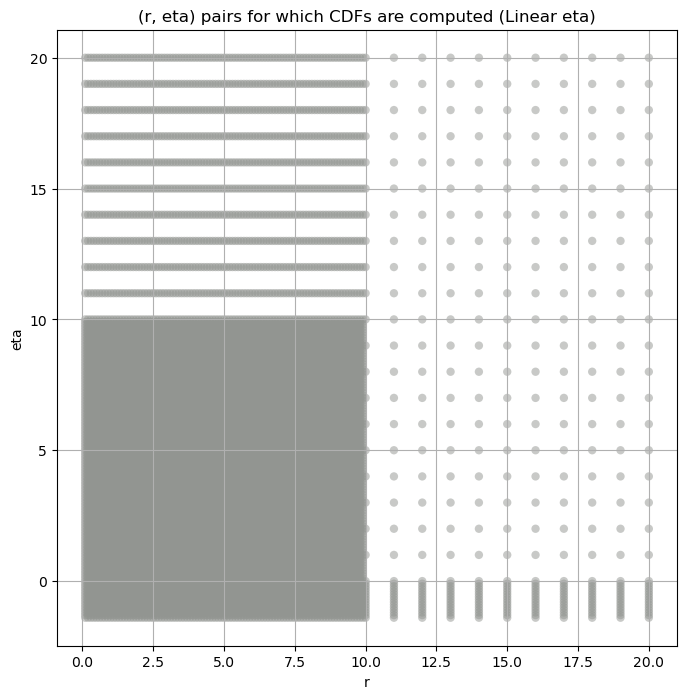

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [9]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [10]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [11]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:18<00:00, 5280.82it/s]


Layer 3


100%|██████████| 100000/100000 [00:26<00:00, 3762.56it/s]


Layer 4


100%|██████████| 100000/100000 [00:25<00:00, 3866.69it/s]


Layer 5


100%|██████████| 100000/100000 [00:26<00:00, 3788.65it/s]


Layer 6


100%|██████████| 100000/100000 [00:24<00:00, 4023.56it/s]


Layer 7


100%|██████████| 100000/100000 [00:25<00:00, 3988.92it/s]


Layer 8


100%|██████████| 100000/100000 [00:25<00:00, 3975.75it/s]


obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1696.189600  1517.783900  1889.853600   3.796600    2.353942   
3       546.266700   515.087160   579.062300   3.272476    2.555443   
4       154.462460   145.019270   164.261180   3.816736    3.066599   
5        35.853176    33.392532    38.437500   5.541130    4.382674   
6         7.102549     6.540381     7.693819   7.751813    5.927745   
7         1.320503     1.204313     1.445969  10.719652    8.014826   
8         0.216768     0.195278     0.241856  15.263584    9.907603   

       kurt_upper  total_samples  
layer                             
2        5.295139         3180.0  
3        4.080620        12720.0  
4        4.774097        50880.0  
5        6.967747       203520.0  
6       10.394491       814080.0  
7       15.655435      3256320.0  
8       31.192720     13025280.0

## Initial Grid Search and Hypothesis Test Plots

In [12]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [13]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      1696.189600    1696.189575     1308.052612     1148.779907   
3       546.266700     546.266724      498.027466      470.623230   
4       154.462460     154.462463      149.505829      146.117706   
5        35.853176      35.853176       34.981544       34.369125   
6         7.102549       7.102549        6.885983        6.741415   
7         1.320503       1.320503        1.271167        1.239213   
8         0.216768       0.216768        0.206087        0.199949   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         1029.419312       929.870972       780.229919       664.239380   
3          449.006378       430.345215       398.914612       373.088470   
4          143.244431       140.668411       136.122147       132.128265   
5           33.852112        33.387642        32.558201        31.839212   
6            6.619112         6.510251         6.321532         6.159132   
7            1.212670         1.189371         1.149032         1.114238   
8            0.194967         0.190651         0.183294         0.177053   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           570.195129       494.316864       430.855438       288.647034  
3           351.191742       331.977234       314.742920       272.168304  
4           128.498230       125.191139       122.145065       114.278946  
5            31.196814        30.606266        30.059822        28.609808  
6             6.014422         5.882872         5.761323         5.442941  
7             1.083318         1.055376         1.029837         0.963513  
8             0.171567         0.166650         0.162176         0.150681

####
Layer  2


100%|██████████| 12760/12760 [00:03<00:00, 3927.03it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.01722580624836434 1696.1896


100%|██████████| 12760/12760 [00:01<00:00, 8617.66it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.01751342651033283 1308.0526


100%|██████████| 12760/12760 [00:01<00:00, 8962.85it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.026256428082381933 1148.7799


100%|██████████| 12760/12760 [00:01<00:00, 8986.30it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.03538978705066664 1029.4193


100%|██████████| 12760/12760 [00:01<00:00, 8983.11it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.04401614897413764 929.871


100%|██████████| 12760/12760 [00:01<00:00, 8978.04it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.06037731199803975 780.2299


100%|██████████| 12760/12760 [00:01<00:00, 8979.43it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.07507197497822315 664.2394


100%|██████████| 12760/12760 [00:01<00:00, 8714.53it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.09047304512479759 570.1951


100%|██████████| 12760/12760 [00:01<00:00, 9022.18it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.10359908558206465 494.31686


100%|██████████| 12760/12760 [00:01<00:00, 9045.38it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.11805811232157115 430.85544


100%|██████████| 12760/12760 [00:01<00:00, 9007.09it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.1578898741056426 288.64703
Number of samples: 3180, Without approximation : 3180.0


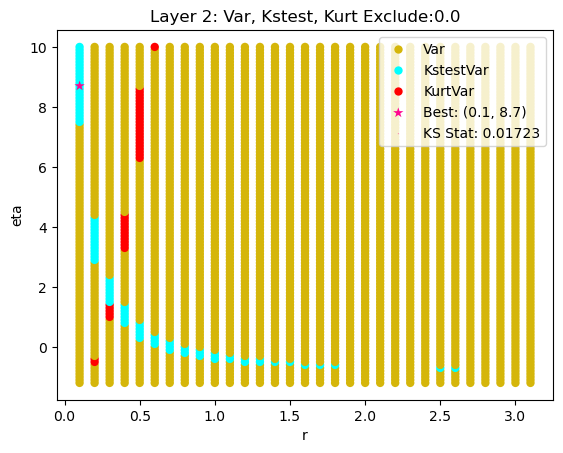

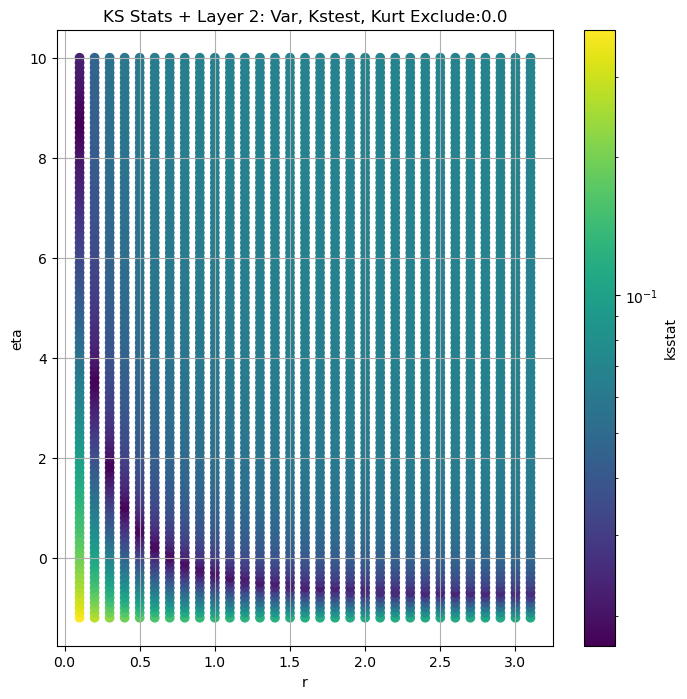

####
Layer  3


100%|██████████| 12760/12760 [00:05<00:00, 2381.80it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.003993899665586942 546.2667


100%|██████████| 12760/12760 [00:05<00:00, 2372.72it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.006048149168714989 498.02747


100%|██████████| 12760/12760 [00:05<00:00, 2400.53it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.008374233497172923 470.62323


100%|██████████| 12760/12760 [00:05<00:00, 2368.53it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.010514509156856033 449.00638


100%|██████████| 12760/12760 [00:05<00:00, 2382.24it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.012383233545961159 430.3452


100%|██████████| 12760/12760 [00:05<00:00, 2376.91it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.01688622932549777 398.9146


100%|██████████| 12760/12760 [00:05<00:00, 2397.18it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.02128334458908454 373.08847


100%|██████████| 12760/12760 [00:05<00:00, 2274.94it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.025449157975912295 351.19174


100%|██████████| 12760/12760 [00:05<00:00, 2302.68it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.02949084801470825 331.97723


100%|██████████| 12760/12760 [00:05<00:00, 2401.24it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.03350332034240744 314.74292


100%|██████████| 12760/12760 [00:05<00:00, 2380.26it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.04502587703055527 272.1683
Number of samples: 12720, Without approximation : 12720.0


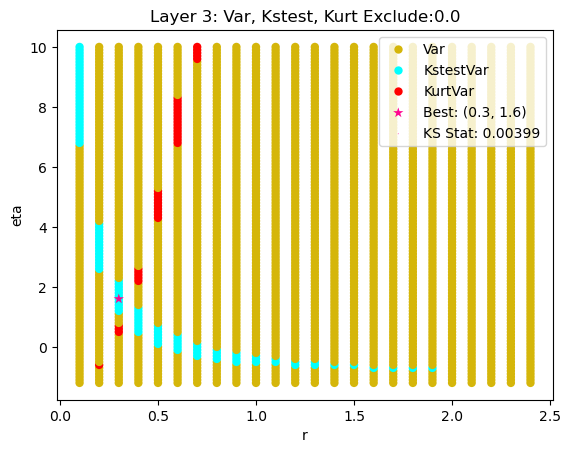

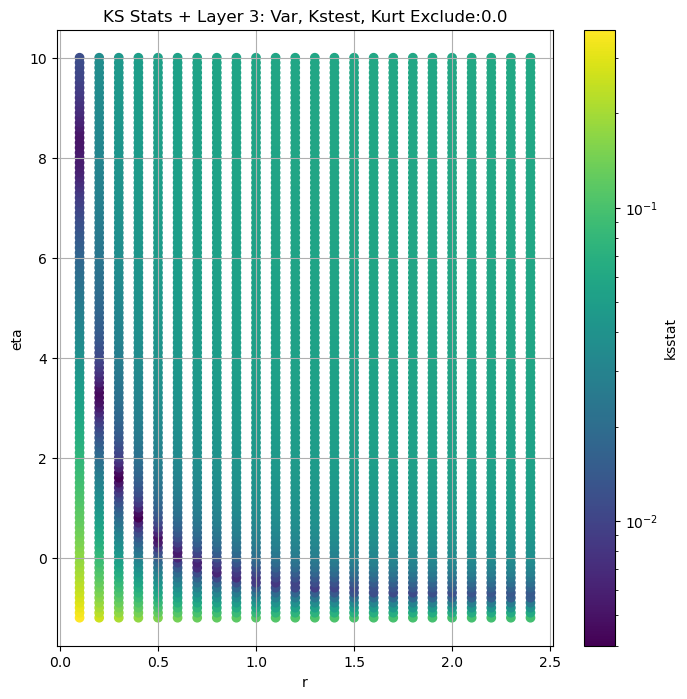

####
Layer  4


100%|██████████| 12760/12760 [00:22<00:00, 563.83it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.005736985534426087 154.46246


100%|██████████| 12760/12760 [00:23<00:00, 551.20it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.00603939055503383 149.50583


100%|██████████| 12760/12760 [00:23<00:00, 542.04it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.005886584997221167 146.1177


100%|██████████| 12760/12760 [00:22<00:00, 561.31it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.005708355356336736 143.24443


100%|██████████| 12760/12760 [00:23<00:00, 543.14it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.0060998462400091435 140.66841


100%|██████████| 12760/12760 [00:22<00:00, 557.71it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.007126899804210218 136.12215


100%|██████████| 12760/12760 [00:23<00:00, 548.53it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.00819284373281104 132.12827


100%|██████████| 12760/12760 [00:22<00:00, 556.77it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.009263513002001678 128.49823


100%|██████████| 12760/12760 [00:22<00:00, 562.72it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.010283365100094977 125.19114


100%|██████████| 12760/12760 [00:22<00:00, 560.41it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.011302235575356256 122.145065


100%|██████████| 12760/12760 [00:22<00:00, 557.60it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.014583699815129858 114.278946
Number of samples: 50880, Without approximation : 50880.0


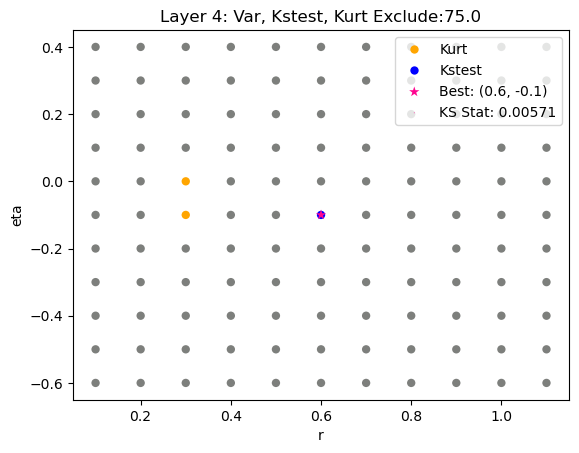

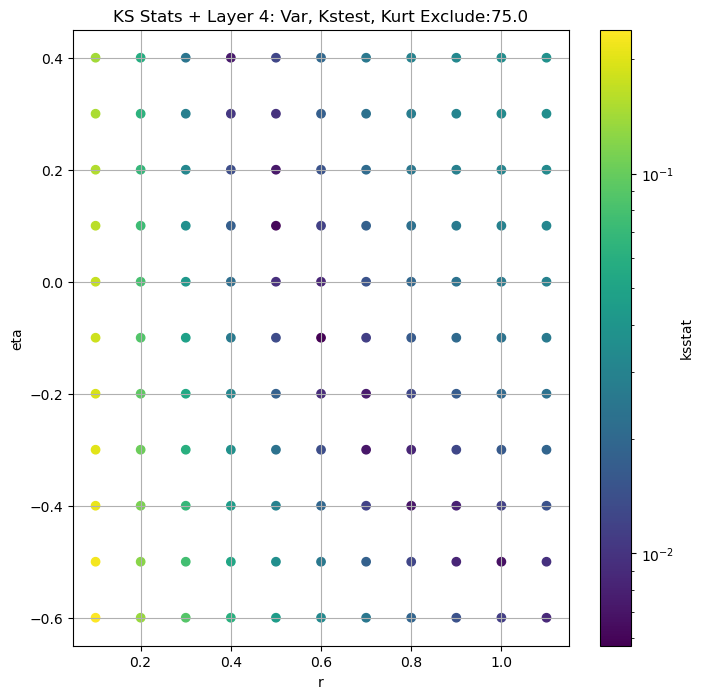

####
Layer  5


100%|██████████| 12760/12760 [00:46<00:00, 277.12it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.0020856653538380288 35.853176


100%|██████████| 12760/12760 [00:46<00:00, 273.71it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.0022706229385425214 34.981544


100%|██████████| 12760/12760 [00:46<00:00, 273.48it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.0028579031915368924 34.369125


100%|██████████| 12760/12760 [00:46<00:00, 277.27it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.0031514628104247766 33.85211


100%|██████████| 12760/12760 [00:46<00:00, 275.38it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.0034204493978737815 33.38764


100%|██████████| 12760/12760 [00:45<00:00, 278.36it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.004267631481990941 32.5582


100%|██████████| 12760/12760 [00:45<00:00, 278.06it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.004859820222135491 31.839212


100%|██████████| 12760/12760 [00:46<00:00, 272.18it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.005365710793054146 31.196814


100%|██████████| 12760/12760 [00:46<00:00, 272.85it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.006020895305224205 30.606266


100%|██████████| 12760/12760 [00:46<00:00, 274.85it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.006627420091822156 30.059822


100%|██████████| 12760/12760 [00:46<00:00, 274.93it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.008331187349022273 28.609808
Number of samples: 100000, Without approximation : 203520.0


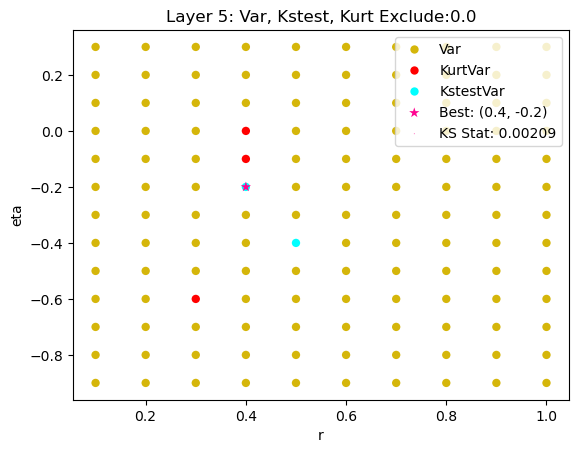

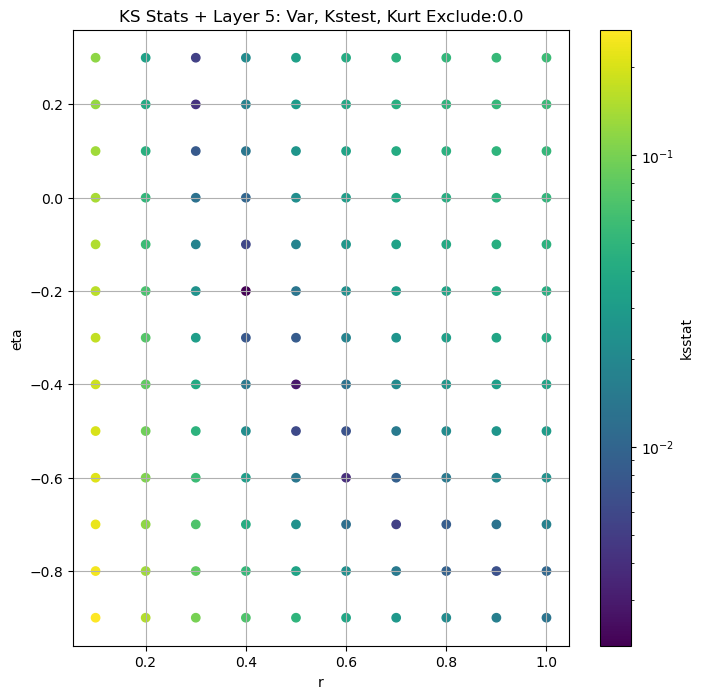

####
Layer  6


100%|██████████| 12760/12760 [00:46<00:00, 274.62it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.004612323651005723 7.1025486


100%|██████████| 12760/12760 [00:46<00:00, 276.27it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.004029999999998424 6.8859835


100%|██████████| 12760/12760 [00:47<00:00, 269.87it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.004029999999998424 6.741415


100%|██████████| 12760/12760 [00:46<00:00, 272.05it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.005060220109147862 6.619112


100%|██████████| 12760/12760 [00:46<00:00, 275.20it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.006147447892263291 6.5102506


100%|██████████| 12760/12760 [00:46<00:00, 275.32it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.0051478679564006535 6.3215322


100%|██████████| 12760/12760 [00:46<00:00, 275.26it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.005503716470442899 6.159132


100%|██████████| 12760/12760 [00:46<00:00, 274.87it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.006161191931481791 6.014422


100%|██████████| 12760/12760 [00:46<00:00, 273.58it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.006796579164785377 5.8828716


100%|██████████| 12760/12760 [00:47<00:00, 267.05it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.007228496521651473 5.761323


100%|██████████| 12760/12760 [00:49<00:00, 258.50it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.008706154812783029 5.4429407
Number of samples: 100000, Without approximation : 814080.0


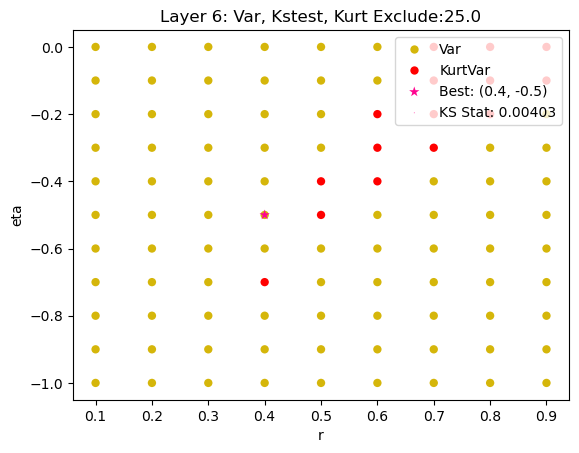

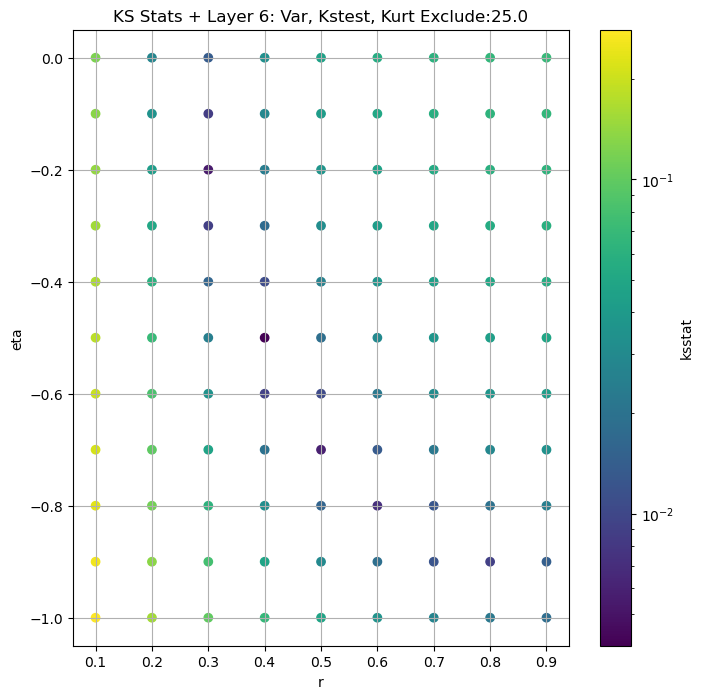

####
Layer  7


100%|██████████| 12760/12760 [00:48<00:00, 262.70it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.009589999999997878 1.3205026


100%|██████████| 12760/12760 [00:47<00:00, 266.70it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.0095899999999981 1.2711673


100%|██████████| 12760/12760 [00:47<00:00, 266.46it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.009589999999997878 1.2392135


100%|██████████| 12760/12760 [00:47<00:00, 268.66it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.009589999999997989 1.2126704


100%|██████████| 12760/12760 [00:47<00:00, 266.29it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.009589999999997878 1.1893712


100%|██████████| 12760/12760 [00:48<00:00, 265.08it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.009589999999997767 1.1490321


100%|██████████| 12760/12760 [00:47<00:00, 267.55it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.009589999999997878 1.1142379


100%|██████████| 12760/12760 [00:47<00:00, 267.95it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.009589999999997767 1.0833176


100%|██████████| 12760/12760 [00:47<00:00, 268.75it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.009589999999997767 1.0553759


100%|██████████| 12760/12760 [00:48<00:00, 265.69it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.009863221484816664 1.0298367


100%|██████████| 12760/12760 [00:48<00:00, 262.77it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.011020526158601385 0.9635135
Number of samples: 100000, Without approximation : 3256320.0


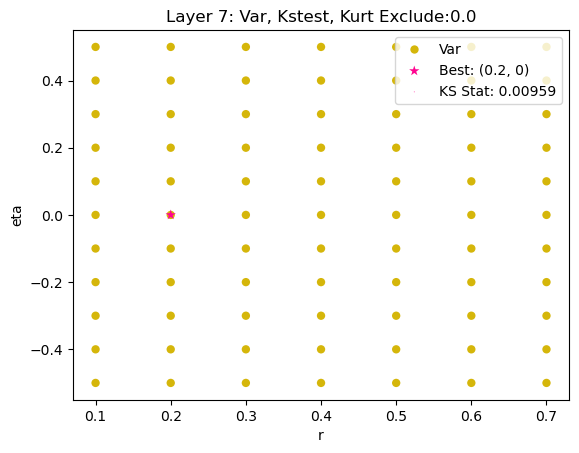

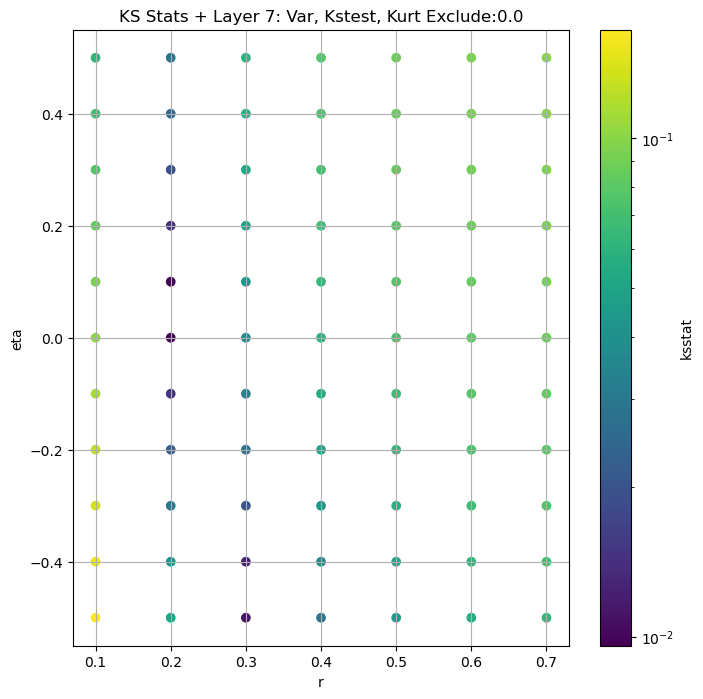

####
Layer  8


100%|██████████| 12760/12760 [00:47<00:00, 270.56it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.029579999999995055 0.21676795


100%|██████████| 12760/12760 [00:46<00:00, 272.11it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.029579999999994944 0.20608707


100%|██████████| 12760/12760 [00:46<00:00, 272.77it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.029579999999994833 0.19994931


100%|██████████| 12760/12760 [00:47<00:00, 270.18it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.029579999999994833 0.19496651


100%|██████████| 12760/12760 [00:46<00:00, 271.91it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.02957999999999472 0.1906514


100%|██████████| 12760/12760 [00:47<00:00, 271.00it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.029579999999994055 0.18329446


100%|██████████| 12760/12760 [00:47<00:00, 267.38it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.029579999999993833 0.17705257


100%|██████████| 12760/12760 [00:48<00:00, 262.32it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.02957999999999439 0.1715667


100%|██████████| 12760/12760 [00:47<00:00, 268.44it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.029579999999994278 0.16665037


100%|██████████| 12760/12760 [00:47<00:00, 270.35it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.029579999999994167 0.16217649


100%|██████████| 12760/12760 [00:47<00:00, 270.97it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.029579999999993944 0.15068077
Number of samples: 100000, Without approximation : 13025280.0


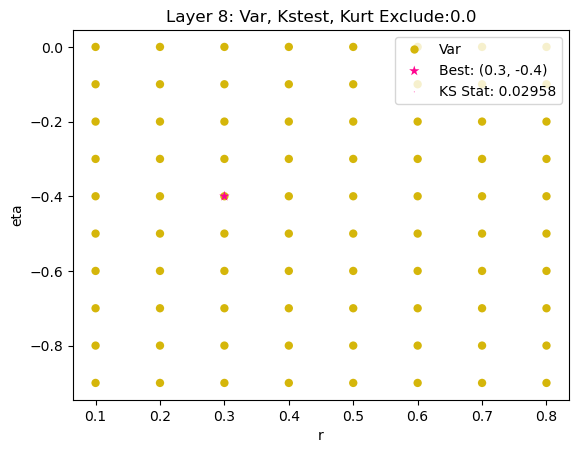

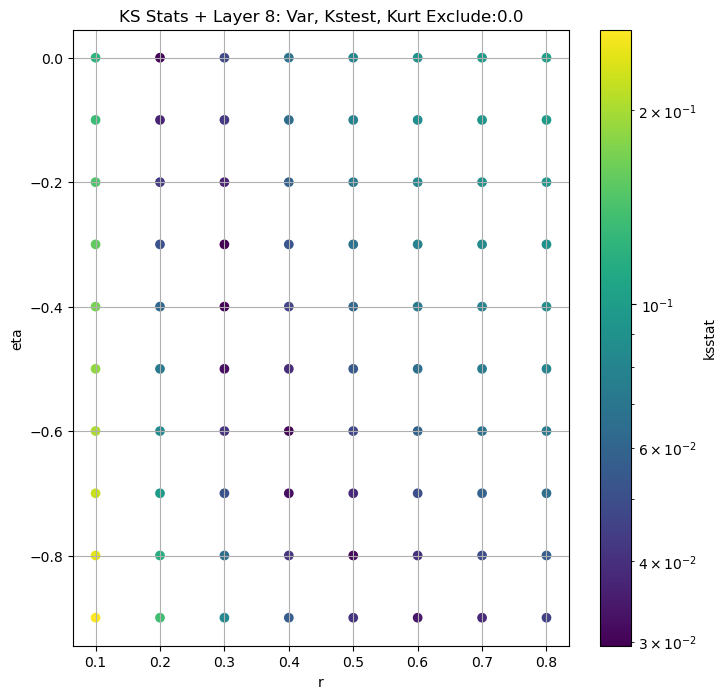

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1696.189600  1517.783900  1889.853600   3.796600    2.353942   
3       546.266700   515.087160   579.062300   3.272476    2.555443   
4       154.462460   145.019270   164.261180   3.816736    3.066599   
5        35.853176    33.392532    38.437500   5.541130    4.382674   
6         7.102549     6.540381     7.693819   7.751813    5.927745   
7         1.320503     1.204313     1.445969  10.719652    8.014826   
8         0.216768     0.195278     0.241856  15.263584    9.907603   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        5.295139         3180.0             0.017226        0.1          8.7   
3        4.080620        12720.0             0.003994        0.3          1.6   
4        4.774097        50880.0             0.005708        0.6         -0.1   
5        6.967747       203520.0             0.002086        0.4         -0.2   
6       10.394491       814080.0             0.004030        0.4         -0.5   
7       15.655435      3256320.0             0.009590        0.2          0.0   
8       31.192720     13025280.0             0.029580        0.3         -0.4   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       9.068987e-18                     0.0         1696.189600   
3       1.608348e-01                     0.0          546.266700   
4       2.842541e+01                    75.0          143.244430   
5       1.160114e+00                     0.0           35.853176   
6       3.814090e-01                    25.0            6.885984   
7       1.805711e-05                     0.0            1.320503   
8       1.207940e-03                     0.0            0.216768   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.024030  
3                     0.012029  
4                     0.006018  
5                     0.003010  
6                     0.001505  
7                     0.000753  
8                     0.000376

In [14]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [15]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 522/522 [00:00<00:00, 2166.37it/s]


Finding Minimum after computing 522 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.046391353199805474, var: 929.8709716796875


100%|██████████| 522/522 [00:00<00:00, 5681.01it/s]


Finding Minimum after computing 522 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.03675194805195292, var: 1029.4193115234375


100%|██████████| 522/522 [00:00<00:00, 9126.07it/s]


Finding Minimum after computing 522 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.028539758806990778, var: 1148.7799072265625


100%|██████████| 522/522 [00:00<00:00, 8708.87it/s]


Finding Minimum after computing 522 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.02159097508637209, var: 1308.0526123046875


100%|██████████| 522/522 [00:00<00:00, 9154.88it/s]


Finding Minimum after computing 522 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.01722580624836434, var: 1696.1895751953125
Number of samples: 3180, Without approximation : 3180.0


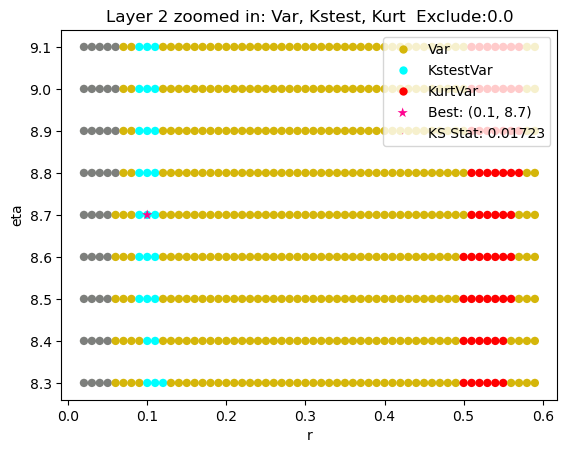

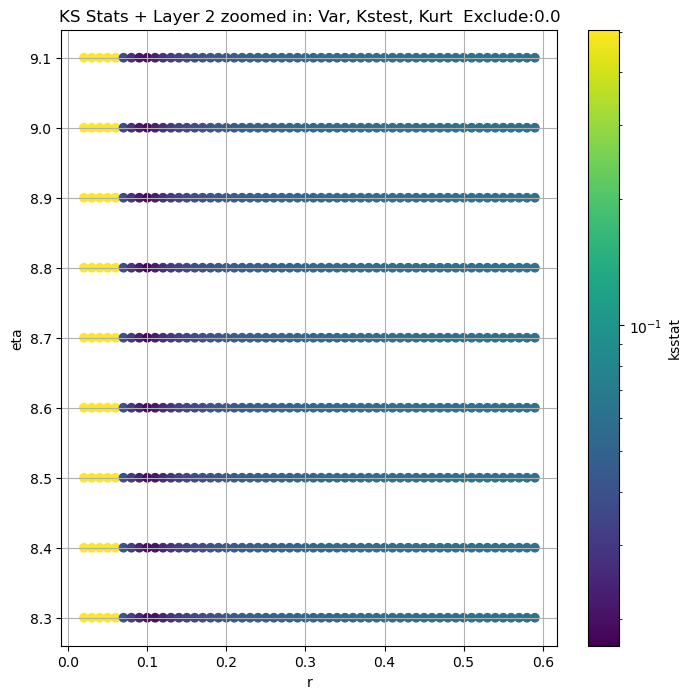

Layer 3


100%|██████████| 702/702 [00:00<00:00, 1224.05it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.015010665492903641, var: 430.34521484375


100%|██████████| 702/702 [00:00<00:00, 2222.70it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.01264996337364721, var: 449.0063781738281


100%|██████████| 702/702 [00:00<00:00, 2168.54it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.010255067946313035, var: 470.62322998046875


100%|██████████| 702/702 [00:00<00:00, 2234.47it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.007538190109969478, var: 498.0274658203125


100%|██████████| 702/702 [00:00<00:00, 2270.29it/s]


Finding Minimum after computing 702 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.0038307312477783295, var: 546.2667236328125
Number of samples: 12720, Without approximation : 12720.0


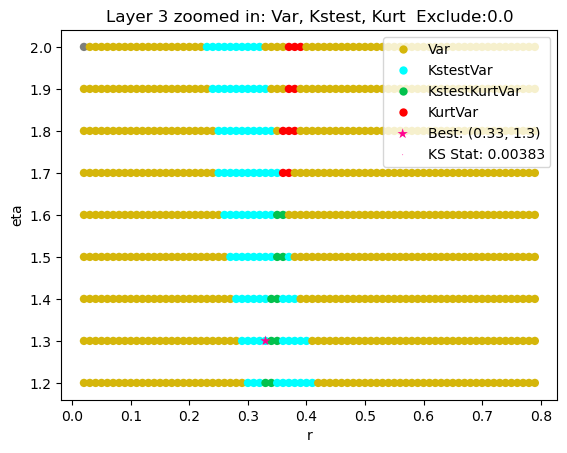

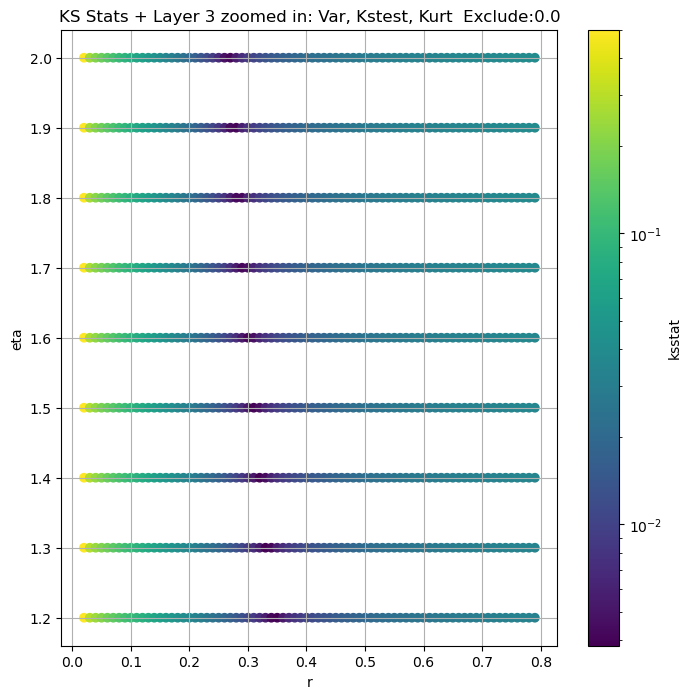

Layer 4


100%|██████████| 1377/1377 [00:02<00:00, 460.98it/s]


Finding Minimum after computing 1377 CDFs
layer 4, 75.0 + 100 = 175, ksstat: 0.007605960048742255, var: 134.08328247070312


100%|██████████| 1377/1377 [00:02<00:00, 558.74it/s]


Finding Minimum after computing 1377 CDFs
layer 4, 75.0 + 75 = 150, ksstat: 0.0070511210163648474, var: 136.1221466064453


100%|██████████| 1377/1377 [00:02<00:00, 566.00it/s]


Finding Minimum after computing 1377 CDFs
layer 4, 75.0 + 50 = 125, ksstat: 0.006485554637926105, var: 138.30873107910156


100%|██████████| 1377/1377 [00:02<00:00, 568.94it/s]


Finding Minimum after computing 1377 CDFs
layer 4, 75.0 + 25 = 100, ksstat: 0.00588586107011857, var: 140.6684112548828


100%|██████████| 1377/1377 [00:02<00:00, 574.10it/s]


Finding Minimum after computing 1377 CDFs
layer 4, 75.0 + 0 = 75, ksstat: 0.005462146732726103, var: 143.2444305419922


100%|██████████| 1377/1377 [00:02<00:00, 557.11it/s]


Finding Minimum after computing 1377 CDFs
layer 4, 75.0 + -25 = 50, ksstat: 0.005463229618131615, var: 146.11770629882812


100%|██████████| 1377/1377 [00:02<00:00, 572.11it/s]


Finding Minimum after computing 1377 CDFs
layer 4, 75.0 + -50 = 25, ksstat: 0.005470293396970416, var: 149.50582885742188


100%|██████████| 1377/1377 [00:02<00:00, 564.06it/s]


Finding Minimum after computing 1377 CDFs
layer 4, 75.0 + -75 = 0, ksstat: 0.005464511486235446, var: 154.46246337890625
Number of samples: 50880, Without approximation : 50880.0


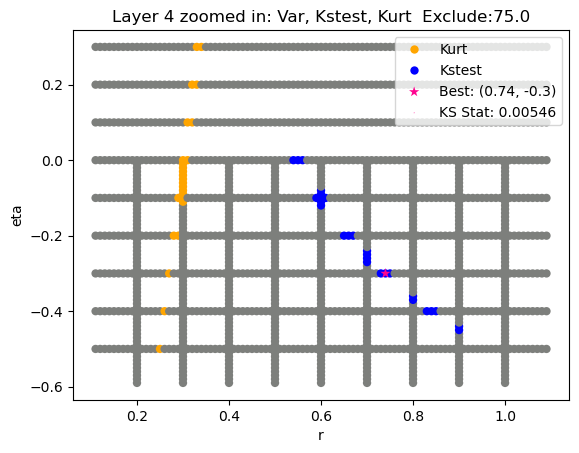

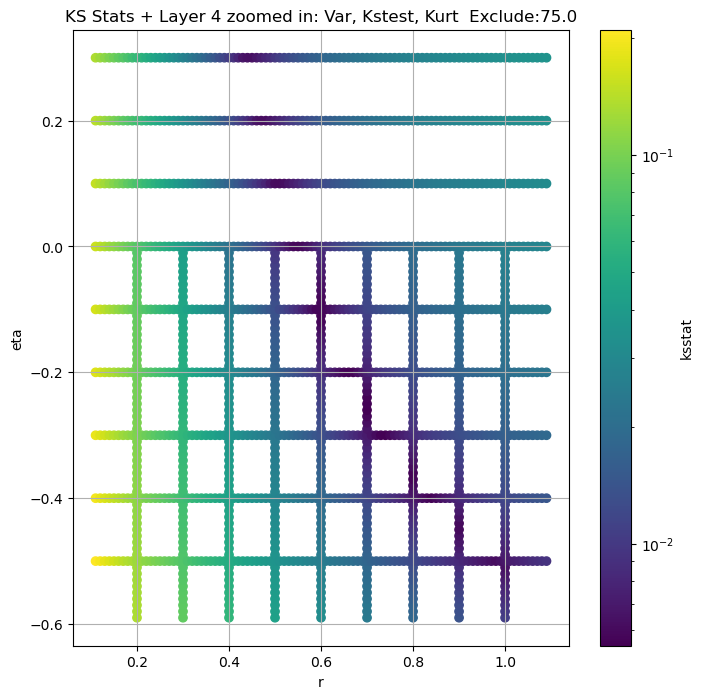

Layer 5


100%|██████████| 1384/1384 [00:05<00:00, 267.68it/s]


Finding Minimum after computing 1384 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.003359867446738496, var: 33.38764190673828


100%|██████████| 1384/1384 [00:04<00:00, 280.79it/s]


Finding Minimum after computing 1384 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.002948840566357913, var: 33.85211181640625


100%|██████████| 1384/1384 [00:04<00:00, 277.53it/s]


Finding Minimum after computing 1384 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.0025775607002790357, var: 34.36912536621094


100%|██████████| 1384/1384 [00:04<00:00, 281.02it/s]


Finding Minimum after computing 1384 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.0020759267733725384, var: 34.981544494628906


100%|██████████| 1384/1384 [00:04<00:00, 280.22it/s]


Finding Minimum after computing 1384 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.0017118516225122504, var: 35.85317611694336
Number of samples: 100000, Without approximation : 203520.0


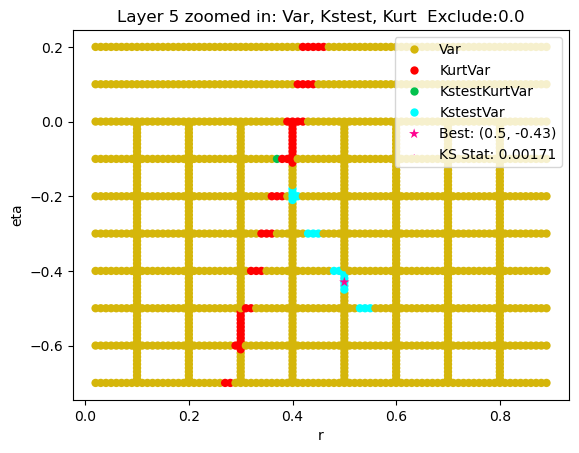

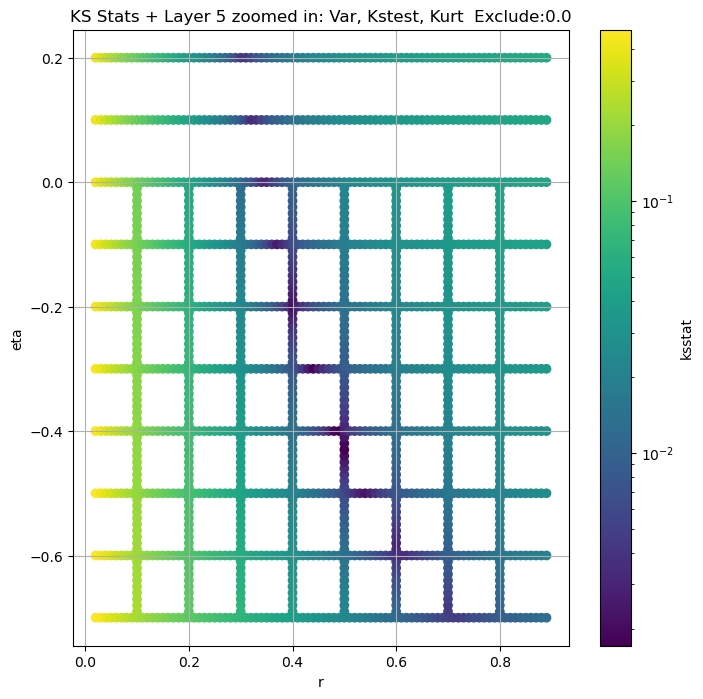

Layer 6


100%|██████████| 1512/1512 [00:05<00:00, 258.41it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 25.0 + 100 = 125, ksstat: 0.004271798447458064, var: 6.412050247192383


100%|██████████| 1512/1512 [00:05<00:00, 277.79it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 25.0 + 75 = 100, ksstat: 0.004108603634757402, var: 6.510250568389893


100%|██████████| 1512/1512 [00:05<00:00, 279.56it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 25.0 + 50 = 75, ksstat: 0.004029999999998202, var: 6.619112014770508


100%|██████████| 1512/1512 [00:05<00:00, 277.28it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 25.0 + 25 = 50, ksstat: 0.004029999999998202, var: 6.741415023803711


100%|██████████| 1512/1512 [00:05<00:00, 280.50it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 25.0 + 0 = 25, ksstat: 0.004029999999998091, var: 6.885983467102051


100%|██████████| 1512/1512 [00:05<00:00, 276.18it/s]


Finding Minimum after computing 1512 CDFs
layer 6, 25.0 + -25 = 0, ksstat: 0.004029999999998091, var: 7.102548599243164
Number of samples: 100000, Without approximation : 814080.0


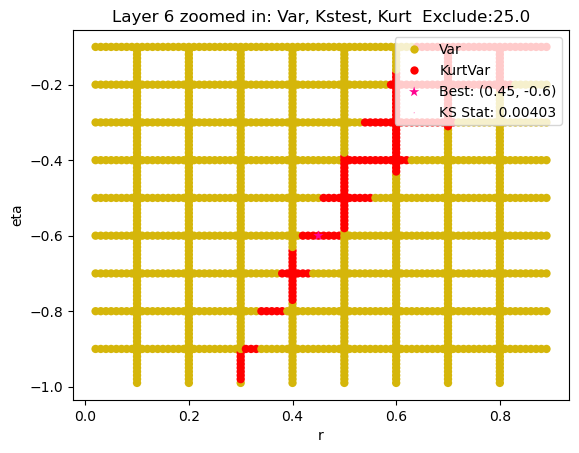

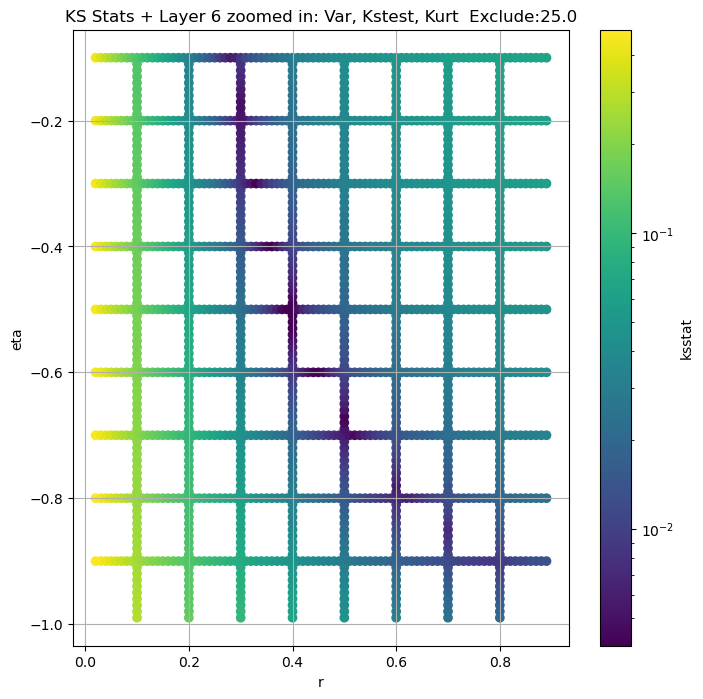

Layer 7


100%|██████████| 936/936 [00:03<00:00, 272.63it/s]


Finding Minimum after computing 936 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.009589999999997767, var: 1.1893712282180786


100%|██████████| 936/936 [00:03<00:00, 261.15it/s]


Finding Minimum after computing 936 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.009589999999997767, var: 1.2126704454421997


100%|██████████| 936/936 [00:03<00:00, 266.64it/s]


Finding Minimum after computing 936 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.009589999999997767, var: 1.239213466644287


100%|██████████| 936/936 [00:03<00:00, 280.37it/s]


Finding Minimum after computing 936 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.009589999999997767, var: 1.271167278289795


100%|██████████| 936/936 [00:03<00:00, 275.83it/s]


Finding Minimum after computing 936 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.009589999999997767, var: 1.3205026388168335
Number of samples: 100000, Without approximation : 3256320.0


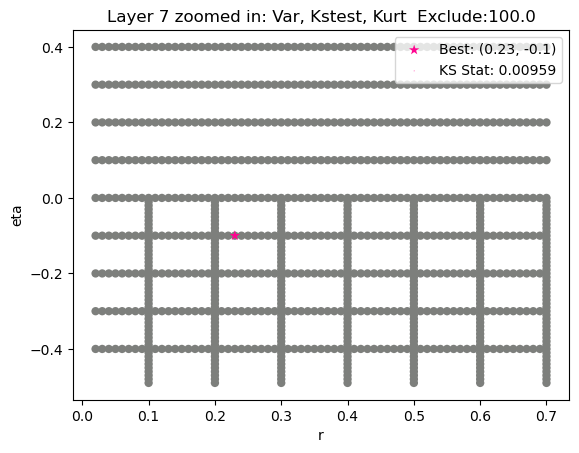

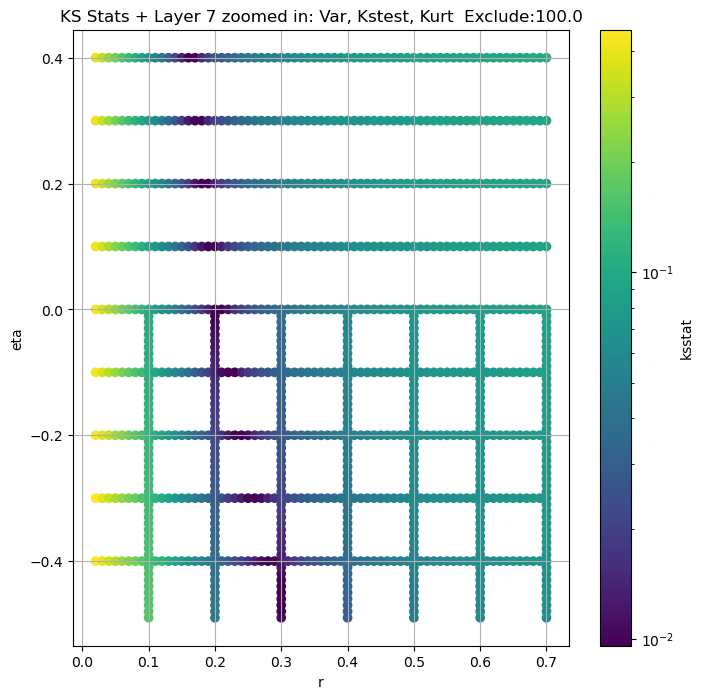

Layer 8


100%|██████████| 1269/1269 [00:04<00:00, 275.24it/s]


Finding Minimum after computing 1269 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.029579999999993722, var: 0.19065140187740326


100%|██████████| 1269/1269 [00:04<00:00, 281.99it/s]


Finding Minimum after computing 1269 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.02957999999999361, var: 0.19496650993824005


100%|██████████| 1269/1269 [00:04<00:00, 271.17it/s]


Finding Minimum after computing 1269 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.029579999999993722, var: 0.19994930922985077


100%|██████████| 1269/1269 [00:04<00:00, 279.92it/s]


Finding Minimum after computing 1269 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.029579999999993833, var: 0.20608706772327423


100%|██████████| 1269/1269 [00:04<00:00, 263.04it/s]


Finding Minimum after computing 1269 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.029579999999994167, var: 0.21676795184612274
Number of samples: 100000, Without approximation : 13025280.0


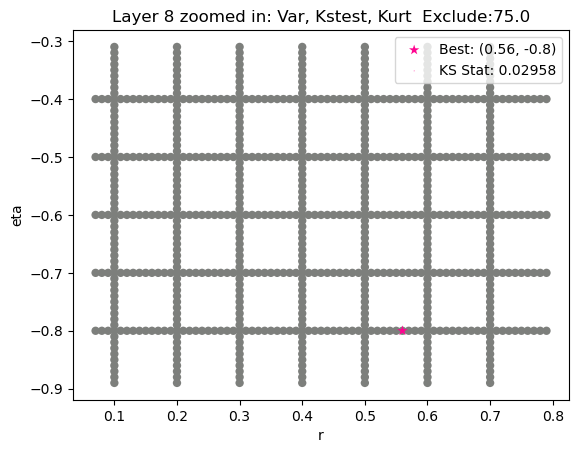

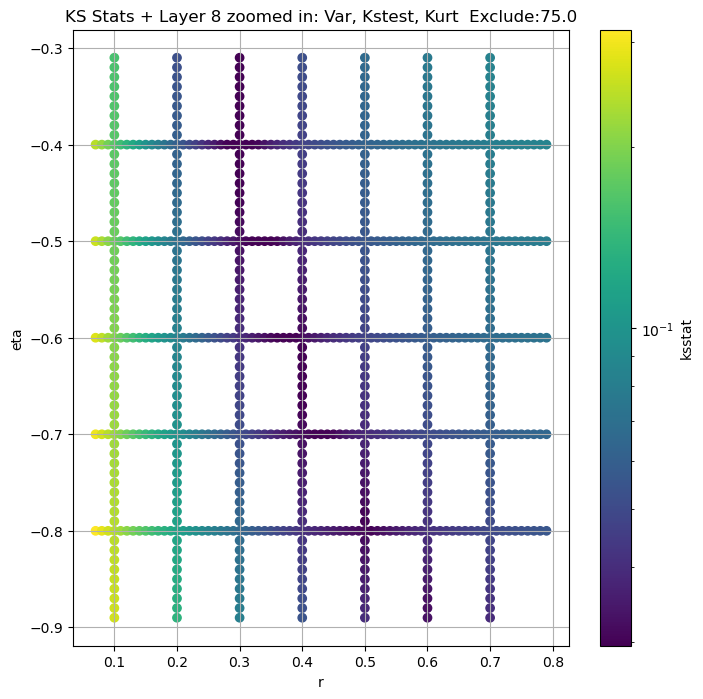

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1696.189600  1517.783900  1889.853600   3.796600    2.353942   
3       546.266700   515.087160   579.062300   3.272476    2.555443   
4       154.462460   145.019270   164.261180   3.816736    3.066599   
5        35.853176    33.392532    38.437500   5.541130    4.382674   
6         7.102549     6.540381     7.693819   7.751813    5.927745   
7         1.320503     1.204313     1.445969  10.719652    8.014826   
8         0.216768     0.195278     0.241856  15.263584    9.907603   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        5.295139         3180.0             0.017226        0.1          8.7   
3        4.080620        12720.0             0.003994        0.3          1.6   
4        4.774097        50880.0             0.005708        0.6         -0.1   
5        6.967747       203520.0             0.002086        0.4         -0.2   
6       10.394491       814080.0             0.004030        0.4         -0.5   
7       15.655435      3256320.0             0.009590        0.2          0.0   
8       31.192720     13025280.0             0.029580        0.3         -0.4   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       9.068987e-18                     0.0         1696.189600   
3       1.608348e-01                     0.0          546.266724   
4       2.842541e+01                    75.0          143.244431   
5       1.160114e+00                     0.0           35.853176   
6       3.814090e-01                    25.0            6.885983   
7       1.805711e-05                     0.0            1.189371   
8       1.207940e-03                     0.0            0.194967   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.024030          0.017226    0.10      8.70   
3                     0.012029          0.003831    0.33      1.30   
4                     0.006018          0.005462    0.74     -0.30   
5                     0.003010          0.001712    0.50     -0.43   
6                     0.001505          0.004030    0.45     -0.60   
7                     0.000753          0.009590    0.23     -0.10   
8                     0.000376          0.029580    0.56     -0.80   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      9.068987e-18                  0.0         6034  
3      6.020135e-01                  0.0       122248  
4      6.579433e+01                 75.0        64395  
5      5.335612e+00                  0.0       651999  
6      8.621942e-01                 25.0       114480  
7      1.698345e-04                100.0        19080  
8      8.547308e-02                 75.0         2011

In [16]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

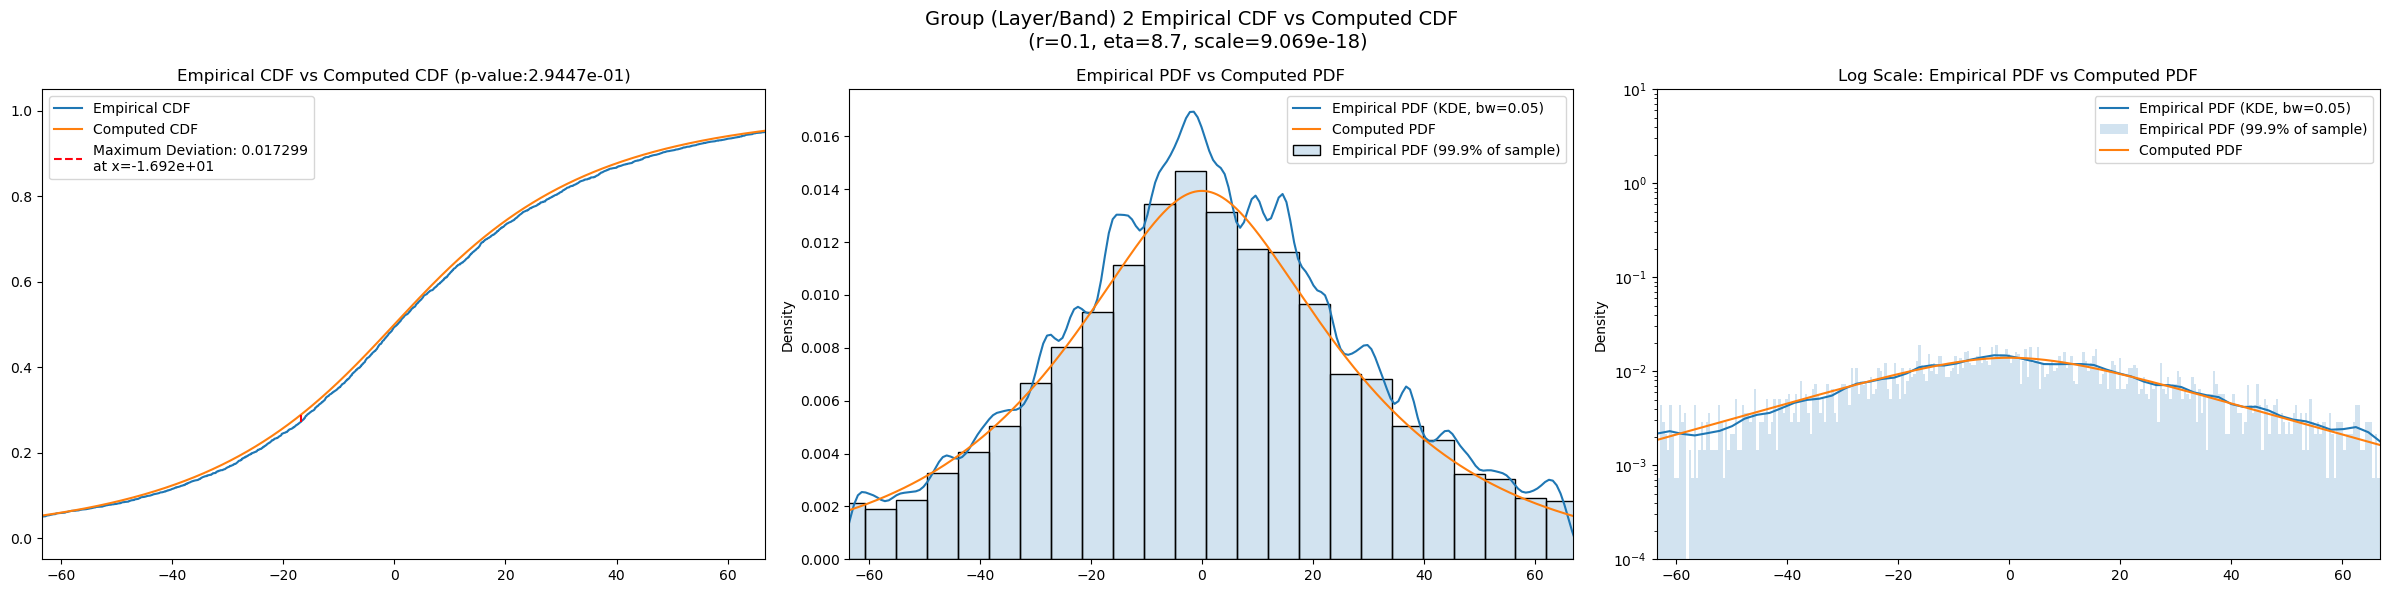

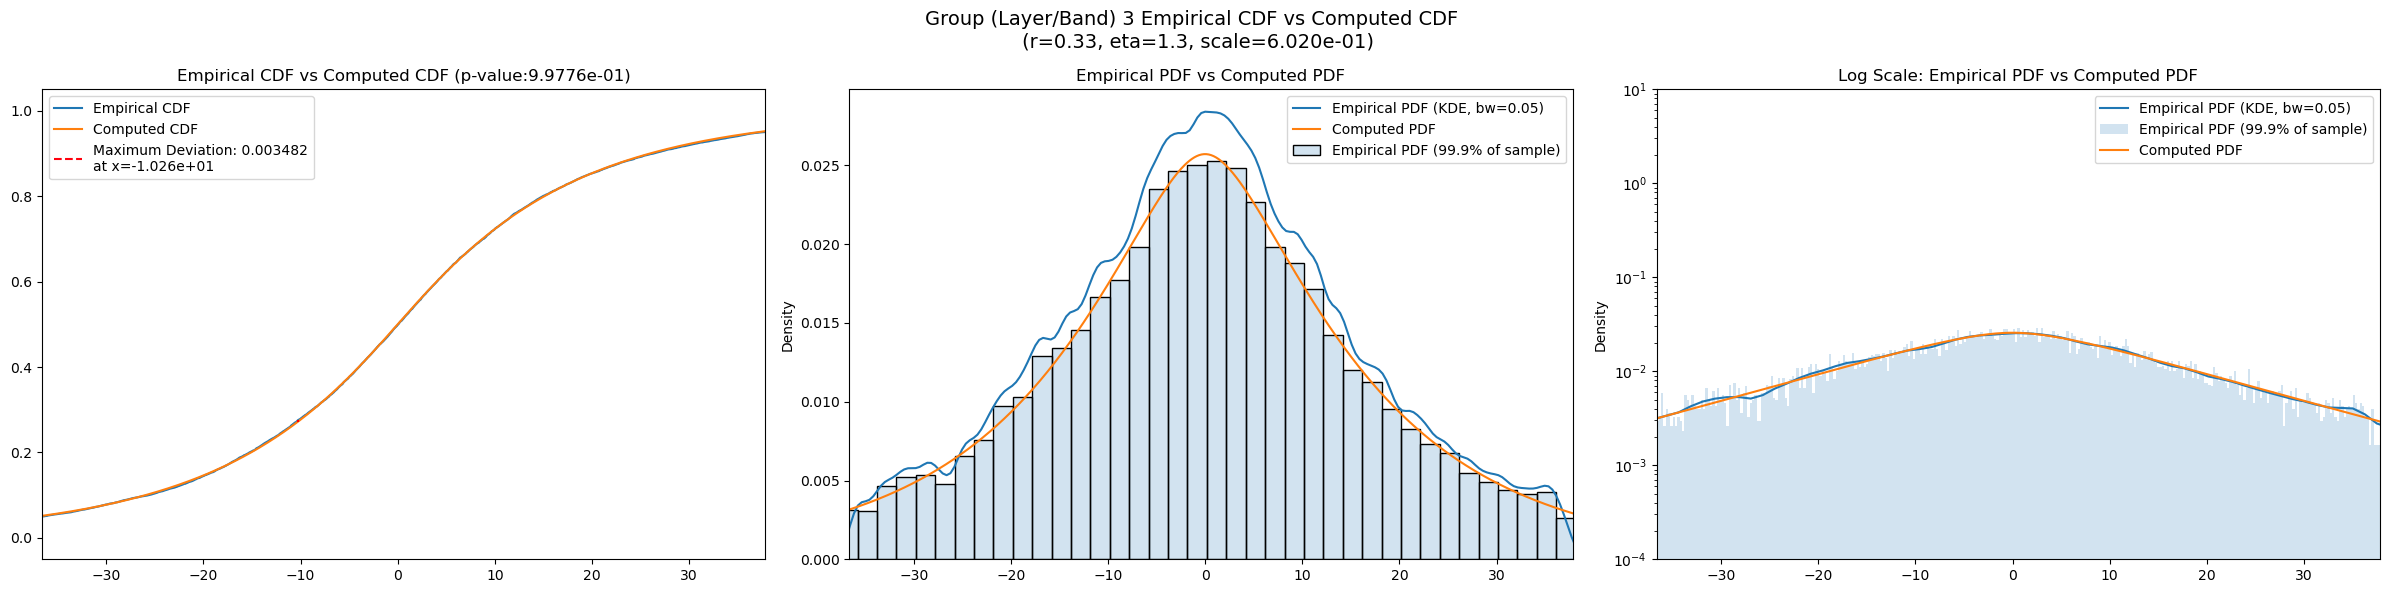

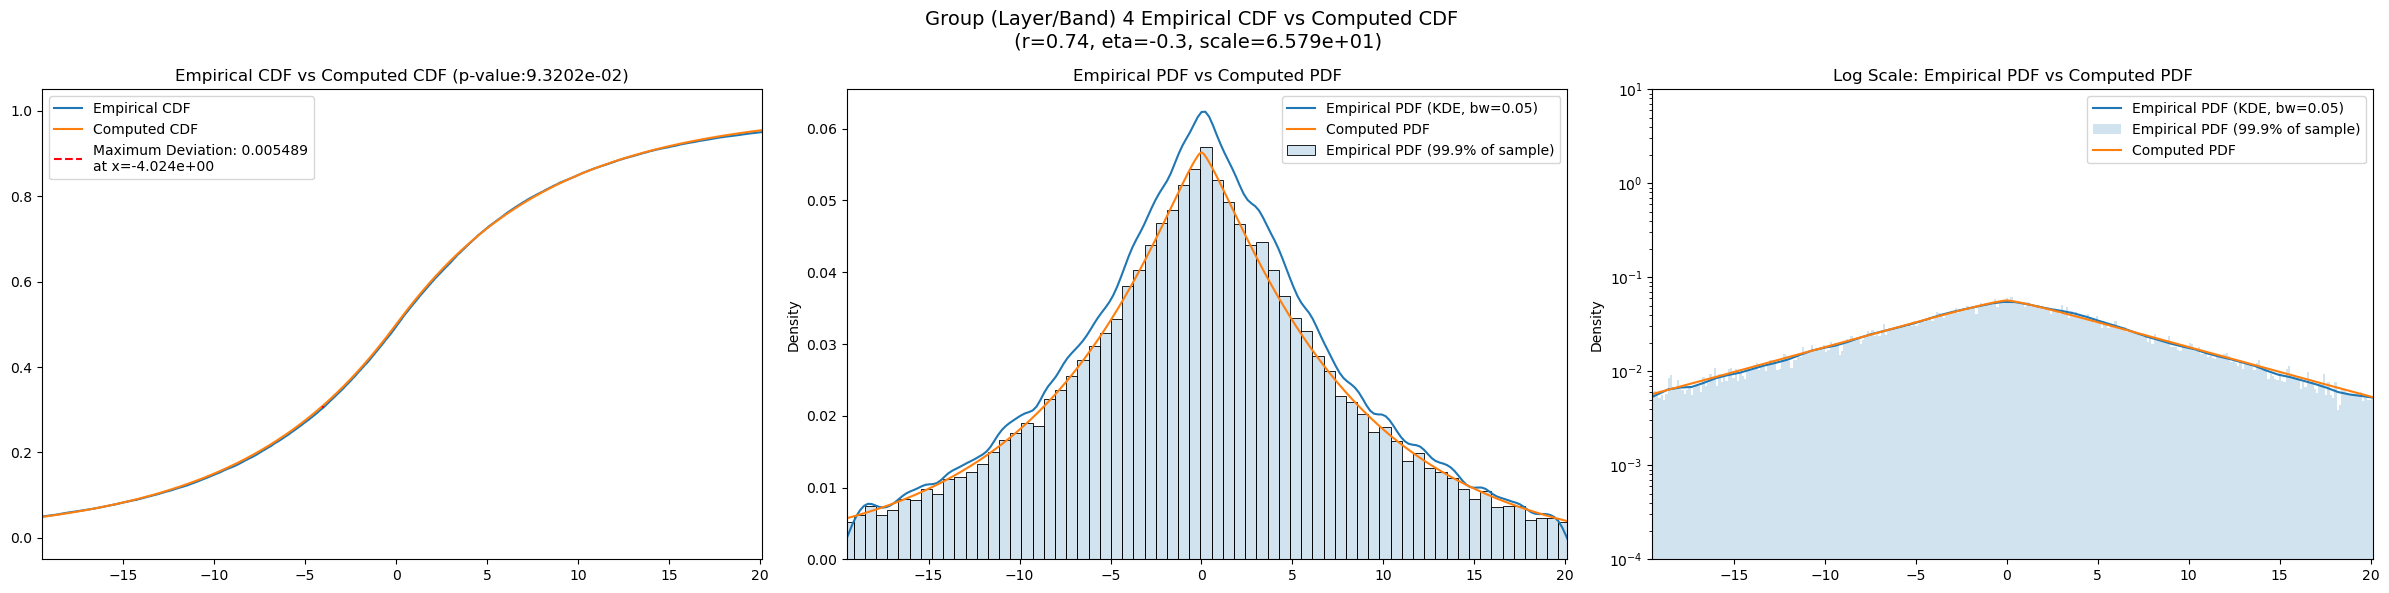

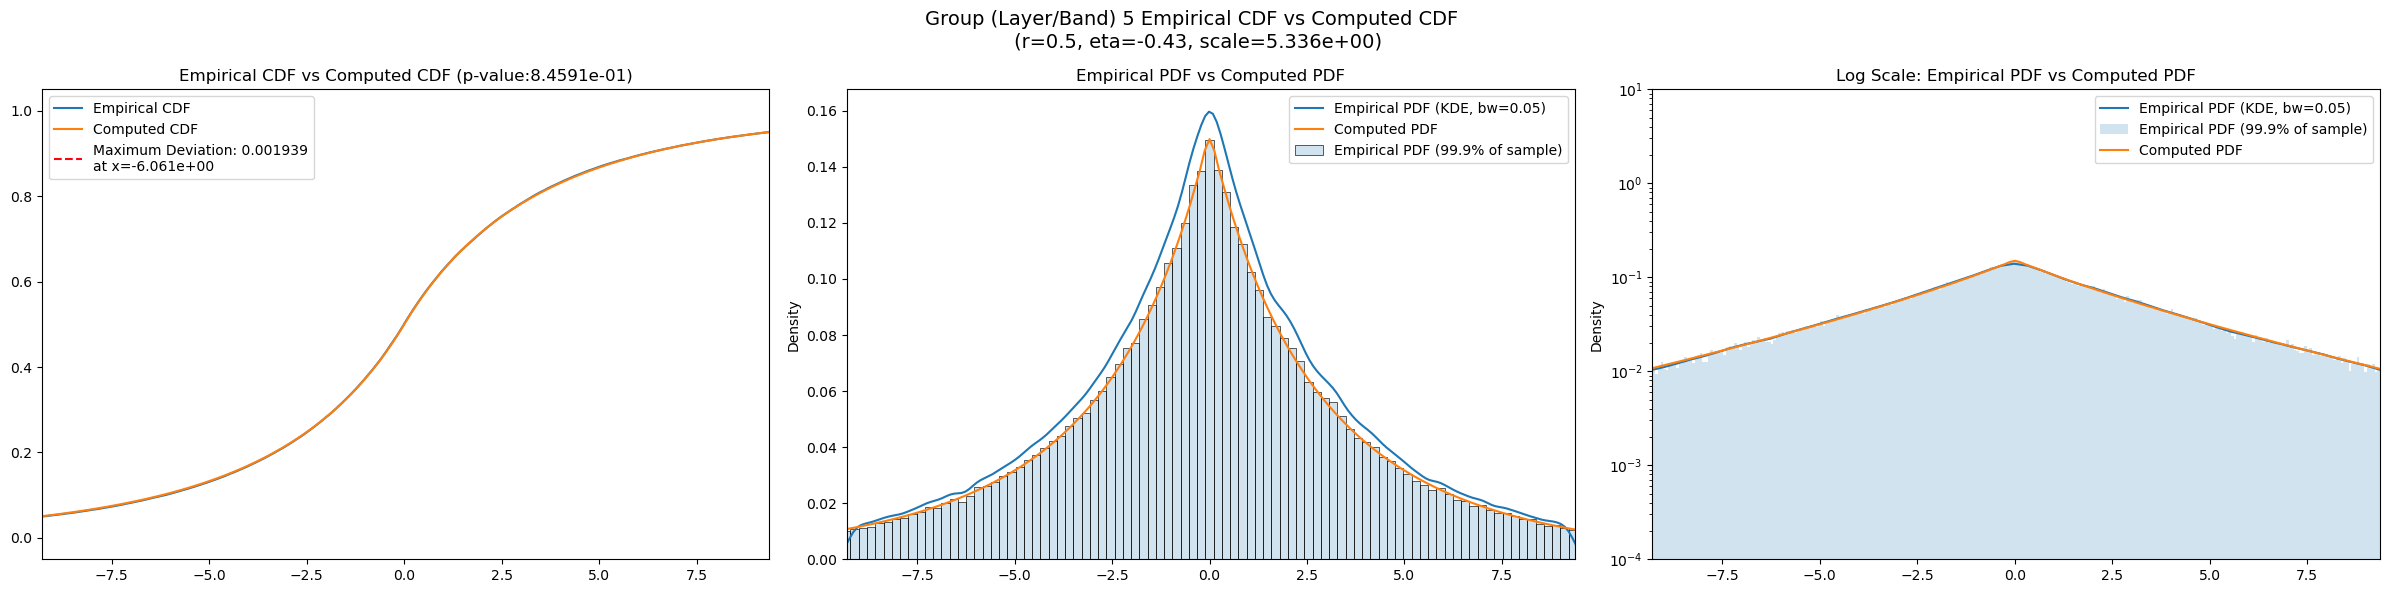

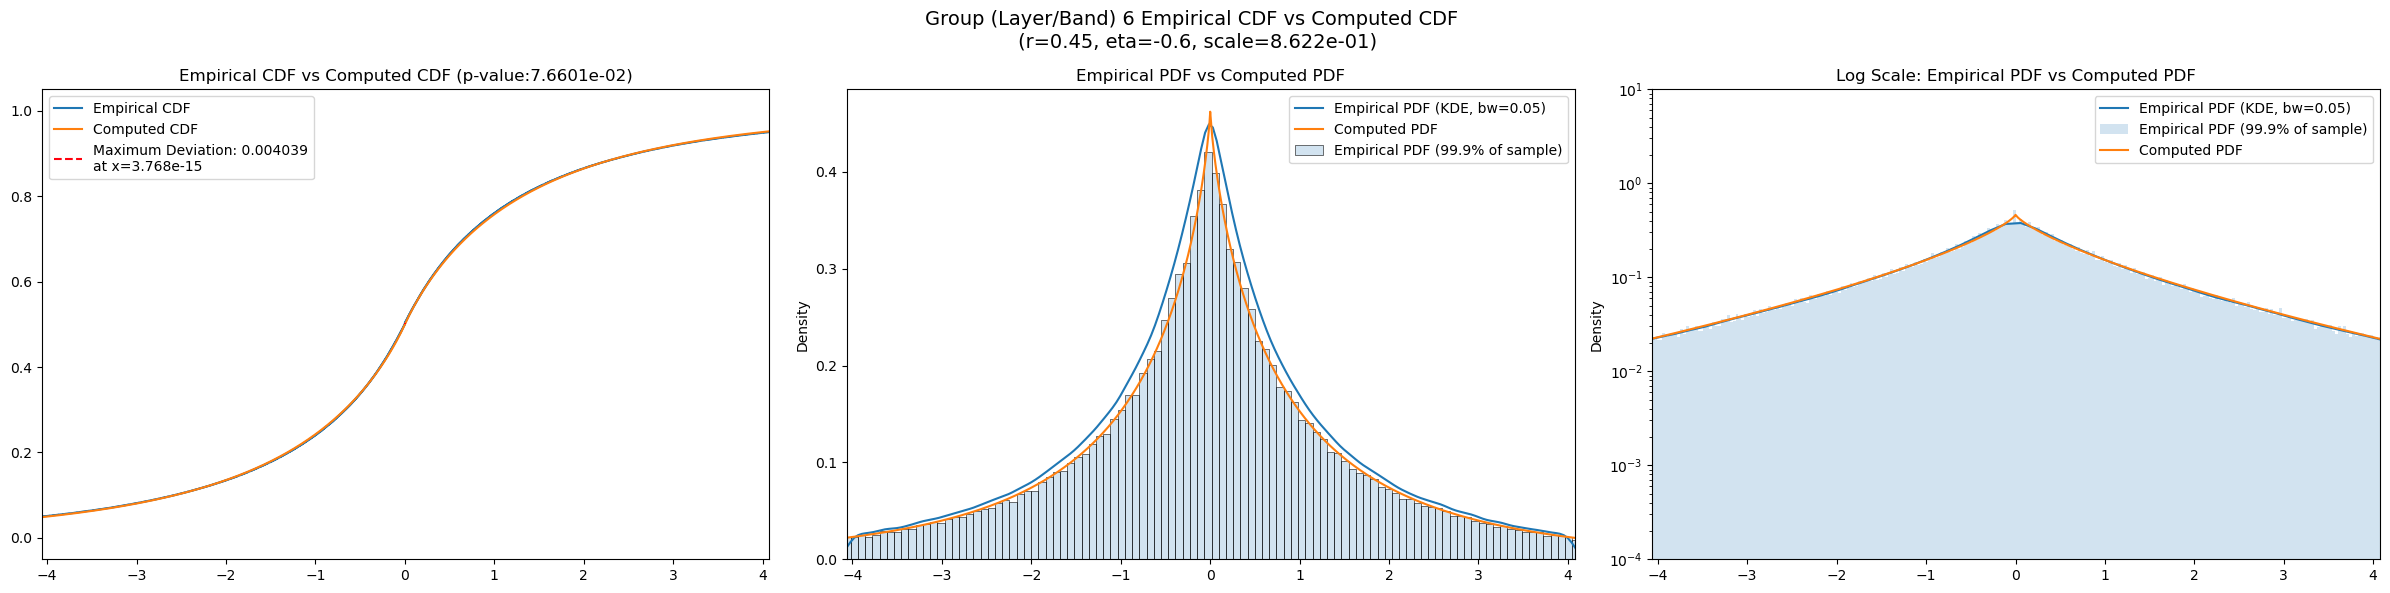

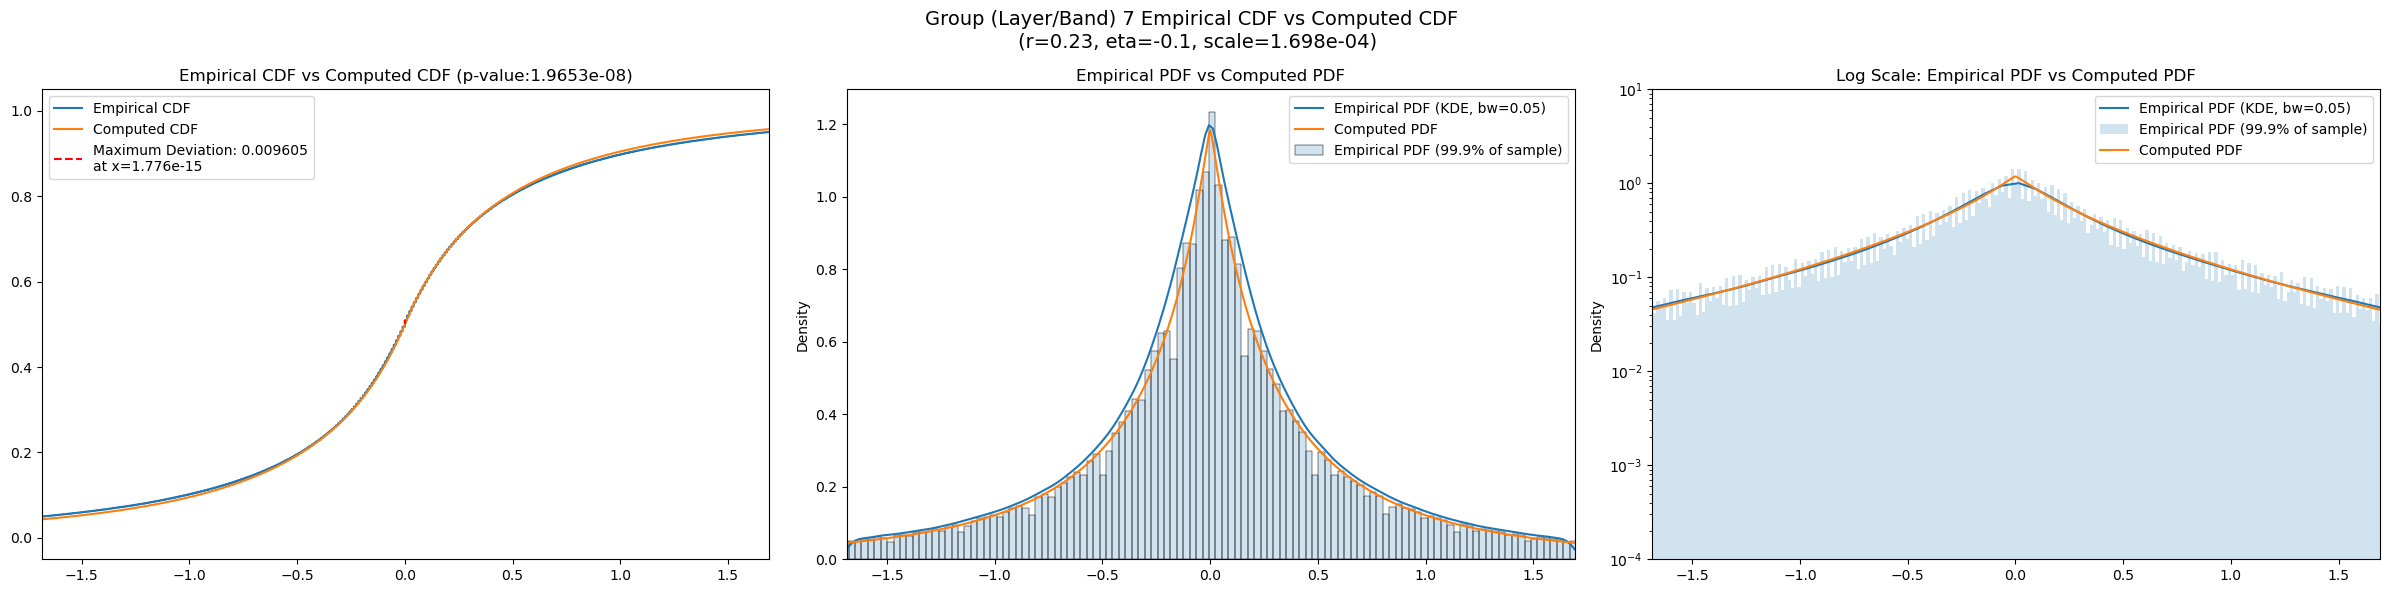

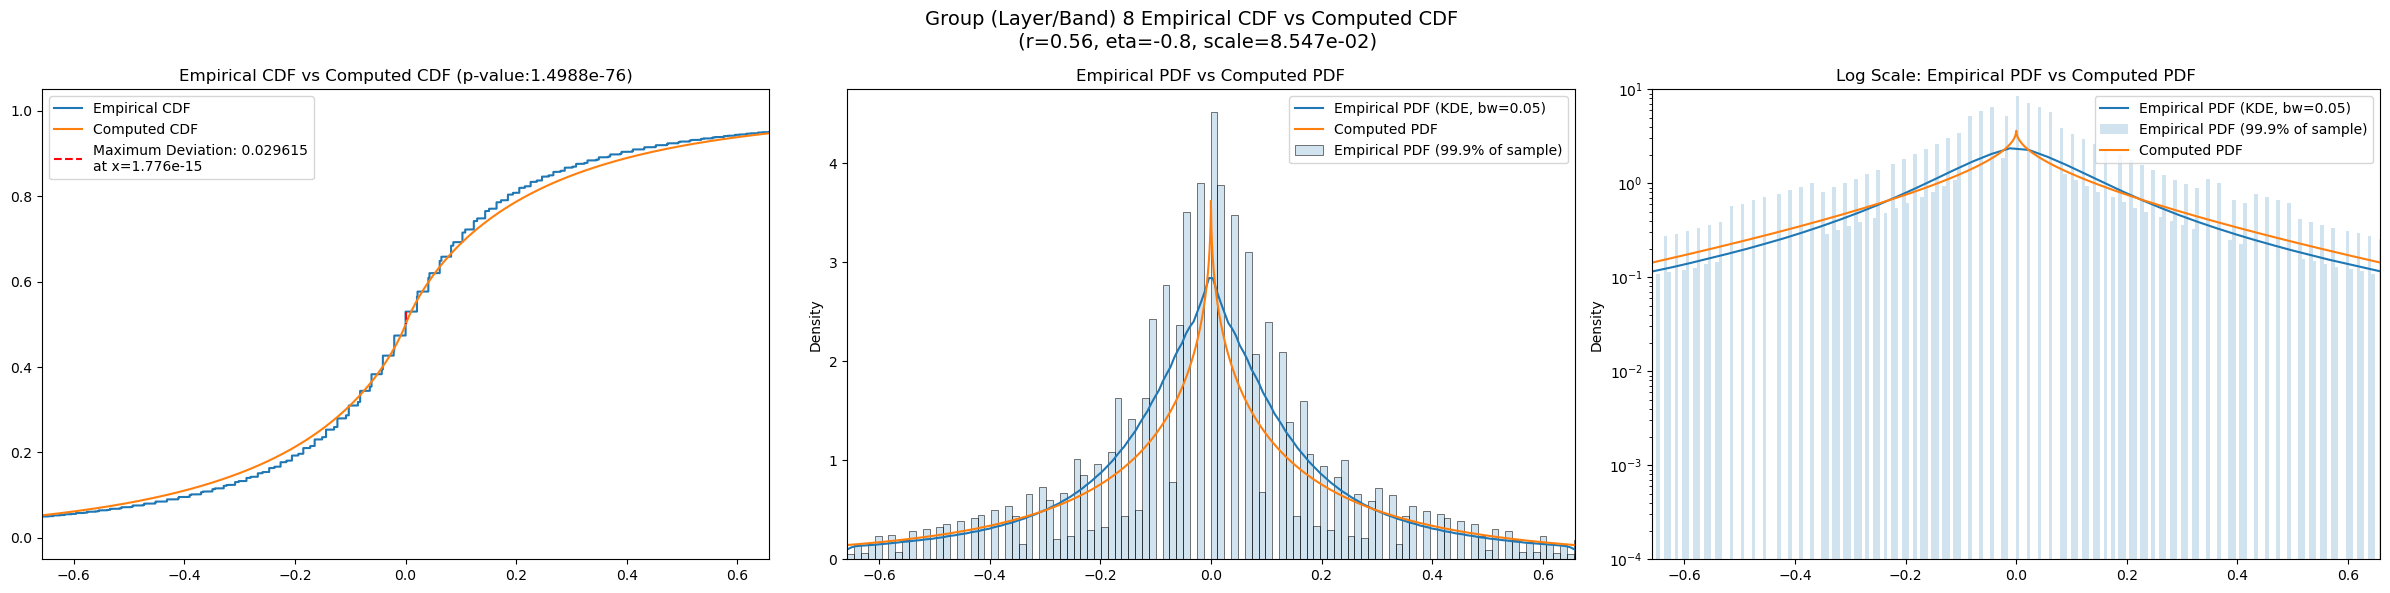

In [17]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [18]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [19]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      1696.189600  1517.783900  1889.853600   3.796600    2.353942   
3       546.266700   515.087160   579.062300   3.272476    2.555443   
4       154.462460   145.019270   164.261180   3.816736    3.066599   
5        35.853176    33.392532    38.437500   5.541130    4.382674   
6         7.102549     6.540381     7.693819   7.751813    5.927745   
7         1.320503     1.204313     1.445969  10.719652    8.014826   
8         0.216768     0.195278     0.241856  15.263584    9.907603   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        5.295139         3180.0             0.017226        0.1          8.7   
3        4.080620        12720.0             0.003994        0.3          1.6   
4        4.774097        50880.0             0.005708        0.6         -0.1   
5        6.967747       203520.0             0.002086        0.4         -0.2   
6       10.394491       814080.0             0.004030        0.4         -0.5   
7       15.655435      3256320.0             0.009590        0.2          0.0   
8       31.192720     13025280.0             0.029580        0.3         -0.4   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       32.943400              0.032992          1.925360e-03   
3      ...       19.278300              0.026266          4.675180e-08   
4      ...        9.585560              0.032821          4.729710e-48   
5      ...        4.246750              0.037929         7.965330e-255   
6      ...        1.671520              0.047234          0.000000e+00   
7      ...        0.635292              0.054471          0.000000e+00   
8      ...        0.245468              0.054655          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          30.544800             0.022702         7.426860e-02  25.284700   
3          16.696100             0.008254         3.495940e-01  13.636900   
4           8.430870             0.006066         4.711630e-02   6.901150   
5           3.722800             0.010595         2.845330e-20   3.004420   
6           1.464350             0.019746        3.784750e-276   1.172610   
7           0.557946             0.027110         0.000000e+00   0.443521   
8           0.213079             0.029580         0.000000e+00   0.165991   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.018571   2.200210e-01          2.985306e-01  
3           0.011845   5.590880e-02          9.918518e-01  
4           0.009433   2.323800e-04          9.569157e-02  
5           0.013621   3.143460e-33          5.892270e-01  
6           0.021799   0.000000e+00          6.544400e-12  
7           0.027202   0.000000e+00         1.497431e-260  
8           0.030698   0.000000e+00          0.000000e+00  

[7 rows x 30 columns]

## Results

In [20]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [21]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.017226                 0.024030          0.017226   
3                 0.003994                 0.012029          0.003831   
4                 0.005708                 0.006018          0.005462   
5                 0.002086                 0.003010          0.001712   
6                 0.004030                 0.001505          0.004030   
7                 0.009590                 0.000753          0.009590   
8                 0.029580                 0.000376          0.029580   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.032992             0.022702       0.018571  
3                  0.026266             0.008254       0.011845  
4                  0.032821             0.006066       0.009433  
5                  0.037929             0.010595       0.013621  
6                  0.047234             0.019746       0.021799  
7                  0.054471             0.027110       0.027202  
8                  0.054655             0.029580       0.030698

In [22]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2             1696.189600          0.017226    0.10      8.70  9.068987e-18   
3              546.266724          0.003831    0.33      1.30  6.020135e-01   
4              143.244431          0.005462    0.74     -0.30  6.579433e+01   
5               35.853176          0.001712    0.50     -0.43  5.335612e+00   
6                6.885983          0.004030    0.45     -0.60  8.621942e-01   
7                1.189371          0.009590    0.23     -0.10  1.698345e-04   
8                0.194967          0.029580    0.56     -0.80  8.547308e-02   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                     75.0  
5                      0.0  
6                     25.0  
7                    100.0  
8                     75.0

In [23]:
eng.quit()